# Notebook 4: Blitztein and Diaconis (2011) Network Simulation
#### Econometric Methods for Networks
#### _Singapore Management University (SMU) May 29th to June 1st, 2017_
##### _Bryan S. Graham, UC - Berkeley, bgraham@econ.berkeley.edu_
<br>
<br>
This is the fourth in a series of iPython Jupyter notebooks designed to accompany a series of instructional lectures given at the Singapore Management University (SMU) from May 29th to June 1st, 2017. The scripts below were written for Python 2.7.12. The Anaconda distribution of Python, available at https://www.continuum.io/downloads, comes bundled with most the scientific computing packages used in these notebooks.
<br>
<br>
For more information about the course please visit my webpage at http://bryangraham.github.io/econometrics/.
<br>
<br>
This notebook provides an implementation of the Blitztein and Diaconis (2011) method for constucting uniform random draws from the set of all adjacency matrices with fixed degree sequences. This code was initially derived from an R implementation by Joseph Blitztein available at http://www.people.fas.harvard.edu/~blitz/Site/Research_files/GraphAlgorithmR.txt. Seonjoo Min provided an initial translation Joseph Blitztein's implementation to Python. What appears in this notebook is a revision of this initial translation to take advantage of additional Python functionality (e.g., routines available in the _networkx_ package). I am also grateful to Andrin Pelican for identifying some errors in an earlier version of this notebook.

In [1]:
# Direct Python to plot all figures inline (i.e., not in a separate window)
%matplotlib inline

# Importing necessary modules
import time
import numpy as np
import copy
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as scs
import networkx as nx

# Division of two integers in Python 2.7 does not return a floating point result. The default is to round down 
# to the nearest integer. The following piece of code changes the default.
from __future__ import division

In [2]:
# Directory where graphics files will be saved
graphics = '/Users/bgraham/Dropbox/Research/Networks/Networks_Book/Graphics/'

This first snippet of code defines all the functions needed to implement the Blitzstein and Diaconis (2011) procedure. As noted above this code follows that of Joseph Blitzstein closely. Changes mostly incorporate extra Python functionality. For example the Erodos-Gallais graphic integer sequence check is available in _networkx_ and hence doesn't need to be hand-coded.

In [3]:
def random_graph_with_fixed_degree(degrees):
    
    """
    Generate random graph with given degree sequence using
    the method of Blitzstein and Diaconis (2011, Internet Math).
    
    INPUTS:
    -------
    degrees      : target degree sequence (of length N, vector of integers)
    
    OUTPUT:
    -------
    log_G_prob   : ex ante log probability of realized sequence of chosen edges
                   (This term is used to construct the importance weights.)
    edges        : edge list associated with simulated graph
    
    CALLS:
    ------
    ...is_valid_degree_sequence_erdos_gallai()... from networkx package
    
    NOTES: Uses several utility functions that are defined below within
           the body of the main function. Method is as described in
           Blitzstein and Diaconis (2011, Internet Mathematics). This
           code was developed by adapting R code by Joseph Blitzstein.
    
    """
    
    #--------------------------------------------------------#
    #- DEFINE SOME UTILITY FUNCTIONS THAT ARE CALLED BY THE -#
    #- MAIN FUNCTION                                        -#
    #--------------------------------------------------------#
    
    def subtract_graphical(degrees, i, j):
    
        """
        Tests whether a residual degree sequence associated with
        degree sequence "degrees" is graphical after adding an edge between 
        vertices i and j.
    
        INPUTS:
        -------
        degrees      : list or numpy 1-dimensional array of integers (vector of integers)
        i, j         : agents who are candidates to be linked (integers)
    
        OUTPUT:
        -------
        True or False boolean according to whether residual degree sequence is graphical 
        after the candidate edge is added
    
        CALLS:
        ------
        ...is_valid_degree_sequence_erdos_gallai()... from networkx package
                   
        """
        
        resid_degrees    = copy.copy(degrees)     # Make copy to avoid modifying the degree
        resid_degrees[i] = resid_degrees[i] - 1   # sequence permanently since it is mutable
        resid_degrees[j] = resid_degrees[j] - 1   
    
        return nx.is_valid_degree_sequence_erdos_gallai(list(resid_degrees))


    def list_candidates(i, degrees, edges, N):
    
        """
        Constructs a list of candidate vertices to which an vertex/agent may be connected without
        generating a residual degree sequence which is non-graphical.
    
        INPUTS:
        -------
        i            : agent/vertex who is to be linked with some other agent (integer)
        degrees      : current (residual) degree sequence (vector of integers)
        edges        : edge list [(1,2),(5,6)...] 
        N            : number vertices in graph (integer)
    
        OUTPUT:
        -------
        candidates   : list of other agents to which vertex may validly be matched
    
        CALLS:
        ------
        ...is_valid_degree_sequence_erdos_gallai()... from networkx package    
        ...subtract_graphical()... 
         
        """
    
        if not nx.is_valid_degree_sequence_erdos_gallai(list(degrees)):
            return "Error: Non-graphical residual degree sequence input in list_candidates()."
    
        candidates = []      # Initialize list of allowable candidates 
    
        # form list of candidates to which the vertex i may be linked while
        # keeping the residual degree sequence graphical
    
        for j in range(0,N):
            # for each j first check whether j!=i and whether (i,j) or (j,i) is already an edge
            if (i != j) and ((i,j) not in edges) and ((j,i) not in edges): 
                # if first condition holds, check for graphicality of residual degree sequence
                if subtract_graphical(degrees, i, j):
                    # if second condition holds then add the edge to candidate list
                    candidates.append(j) 
                    
        return candidates                
    
    def connect_vertex(i, degrees, edges, N):
    
        """
        Connect vertex i to another agent at random from a list of candidates
        such that the new edge will not produce a non-graphical residual degree
        sequence. Note both "degrees" and "edges" are updated by this function.
    
    
        INPUTS:
        -------
        i            : agent who is to be linked with some other agent (integer)
        degrees      : residual degree sequence (vector of integers)
        edges        : edge list [(1,2),(5,6)...]
        N            : number vertices in graph (integer)
    
        OUTPUT:
        -------
        Returns the probability with which the chosen partner was selected.
    
        CALLS:
        ------
        ...list_candidates()...
    
        """
    
        candidates     = list_candidates(i, degrees, edges, N)  # get list of candidate partners
        num_candidates = len(candidates)                        # count number of canidates
            
        if not candidates:
            return "Error: Candidate list is empty."
               
        # use fancy indexing to construct numpy 1d array of candidates' residual degrees
        candidate_degrees = degrees[candidates] 
    
        # compute selection probability for each j in candidate list
        p = (candidate_degrees / np.sum(candidate_degrees))   
    
        # choose random candidate based on selection probabilities
        j = np.random.choice(candidates,1,False,p)[0] 
       
        # update residual degree sequence and add (i,j) to the edge list
        degrees[i] = degrees[i] - 1                        
        degrees[j] = degrees[j] - 1
        edges.append((i,j))                  
    
        # return selection probability for chosen edge
        # NOTE: candidates.index(j) returns index of vertex j in candidates list
        
        return p[candidates.index(j)]

    def connect_vertex_completely(i, degrees, edges, N):
    
        """
        This function keeps randomly adding edges to a vertex until is residual degree 
        sequence is zero. Note both "degrees" and "edges" are updated by this function.
    
        INPUTS:
        -------
        i            : agent who is to be linked with some other agent (integer)
        degrees      : residual degree sequence (vector of integers)
        edges        : edge list [(1,2),(5,6)...] 
        N            : number vertices in graph (integer)
    
        OUTPUT:
        -------
        p_i          : probability of vertex i's rooted network
    
        CALLS:
        ------
        ...connect_vertex()...
    
        """
    
        # add first edge to vertex i and return its (log) probability
        p_i = connect_vertex(i, degrees, edges, N) 
    
        # add remaining edges to i until is residual degree sequence is zero
        # build up overall probability of particular rooted network (conditional on
        # residual degree sequence) along the way
        while degrees[i] > 0:                      
            p_i *= connect_vertex(i, degrees, edges, N)
        
        return p_i

    #--------------------------------------------------------#
    #- START OF MAIN BODY OF FUNCTION                       -#
    #--------------------------------------------------------#

    # COMMENT: the nx.is_valid_degree_sequence_erdos_gallai() only
    #          takes list input. The rest of the function prefers
    #          a numpy integer array.
    
    if not nx.is_valid_degree_sequence_erdos_gallai(list(degrees)):
        return "Error: Non-graphical degree sequence input in random_graph_with_fixed_degree()."
    
    N       = len(degrees)                     # number of agents or vertices in network
    degrees = np.array(degrees, dtype = int)   # copy degree sequence into numpy 1d array
    
    # the ex ante that a particular graph is chosen by the algorithmn equals
    # the probability that a particular sequence of edges is chosen times the
    # number of different ways that edge set could be chosen
    
    # initialize probability of simulated network
    log_G_prob  = 0    # initialize log_G_prob (= log(sigma*c) + scaling_adj) selection probability 
    edges       = []   # initialize edge list
    
    # find initial vertex with smallest positive residual degree
    try:
        i        = list(degrees).index(np.min(degrees[degrees>0]))       
        degree_i = degrees[i]
    except:
        degree_i = 0                    
    
    # keep adding edges to graph until residual degree sequence is zero
    while degree_i>0: 
        # numbers of ways current batch of edges could have been added
        orders_i = np.math.factorial(degree_i) 
        
        # add all needed edges to i and calculate probability of chosen sequence
        # NOTE: edge list and residual degree sequence should be update automatically
        p_i      = connect_vertex_completely(i, degrees, edges, N)
        
        # update ex ante probability of current graph 
        # NOTE: compute sum of log probabilities to help avoid underflow issues  
        log_G_prob  += np.log(p_i*orders_i)
        
        # find new vertex with smallest positive residual degree
        try:
            i        = list(degrees).index(np.min(degrees[degrees>0]))       
            degree_i = degrees[i]
        except:
            degree_i = 0
    
    return [log_G_prob, edges]
  
def simulate_random_graph_with_fixed_degree(degrees, S):
    
    """
    Generates random graphs with degree sequence "degrees" and combines the results with 
    importance weights to estimate the number of graphs with degree sequence "degrees". 
       
    INPUTS:
    -------
    degrees      : residual degree sequence (vector of integers)
    S            : number of simulated graphs to generate (integer)
    
    OUTPUT:
    -------
    graphs                   : list of S edge lists for each simulated graph
    stb_iwgts                : list of stabilized iwgts = iwgts / sum(iwgts)
                               (can be used to estimate expectations; such as average transitivity)
    iwgts                    : list of S importance weuights (not stabilized)
    estimated_size_of_set    : estimate number of graphs with degree sequence equal to "degrees" 
    estimated_size_of_set_se : standard error of above
    
    NOTE: These last three outputs will be set equal to "None" if
          any elements of iwgt evaluate to infinity due to
          underflow issues. This can happen for large graphs.
          In such cases the size of the set can't be precisely
          estimated, but the stabilized weights can be used
          to estimate expectations and so on.] 
    
    CALLS:
    ------
    ...random_graph_with_fixed_degree()...
    
    """
    
    # initialize list of log probability weights and edge lists
    log_G_probs  = []
    graphs = []
    
    # count number of agents/vertices with non-zero degree
    N_pos_degree = np.count_nonzero(degrees)
    
    for i in range(0,S):
        
        start = time.time()
        
        [log_G_prob, edges] = random_graph_with_fixed_degree(degrees)
    
        # add log probability weight and edge list to relevant lists
        log_G_probs.append(log_G_prob)
        graphs.append(edges)
                
        end = time.time()
        
        if (i+1) % 5 == 0:
            print "Time required for simulation  " + str(i+1) + " of " + str(S) + ": " + str(end-start)

    # compute stabilized weights
    stabilizer = np.mean(np.asarray(log_G_probs))
    stb_iwgts = np.exp(stabilizer - np.asarray(log_G_probs))
    stb_iwgts = stb_iwgts / np.sum(stb_iwgts)
            
    # compute estimate of size of set of graphs with N = len(degrees) vertices and given
    # degree sequence
    iwgts = np.array(np.exp(-np.asarray(log_G_probs)))
    estimated_size_of_set    = np.mean(iwgts)
    estimated_size_of_set_se = np.std(iwgts)/np.sqrt(S)
    
    if np.any(np.isinf(iwgts)):
        iwgts = None
        estimated_size_of_set = None
        estimated_size_of_set_se = None        
        
    return [graphs, stb_iwgts, iwgts, estimated_size_of_set, estimated_size_of_set_se]

Next load the Nyakatoke adjacency matrix from GitHub.

In [4]:
# Load Nyakatoke Adjacency matrix (sparse matrix file created in Notebook #1)
from scipy import io

# Location of saved adjacency matrix
adj_location = '/Users/bgraham/Dropbox/Teaching/Short_Courses/St_Gallen/Data/Created/' 

# Load matrix and convert to numpy 2d array
NyakatokeTestDataset = io.mmread(adj_location+"Nyakatoke_Adjacency.mtx")
Nyakatoke_adjM = NyakatokeTestDataset.toarray()

This final snippet of code draws _S_ networks from the set of all networks with degree sequences coinciding with the one observed in Nyakatoke. It computes the triad census in each sampled network as well as the transivity index.

In [5]:
#--------------------------------------------------%
#- Calculate degree sequence of Nyakatoke network -%
#--------------------------------------------------%

Nyakatoke_degrees = list(np.sum(Nyakatoke_adjM, axis=0, dtype=int))
N = len(Nyakatoke_degrees)

#------------------------------------------------#
#- Draw S networks at random from reference set -#
#------------------------------------------------#
S = 1000
[graphs, stb_iwgts, iwgts, estimated_size_of_set, estimated_size_of_set_se] = \
        simulate_random_graph_with_fixed_degree(Nyakatoke_degrees, S)

print("Completed simulation of reference graphs.")

#-------------------------------------#
#- Triad Census & Transitivity Index -#
#-------------------------------------#

G = nx.from_numpy_matrix(Nyakatoke_adjM)
Nyakatoke_TwoStar = nx.triadic_census(G.to_directed())['201']    # Two star
Nyakatoke_Triangle = nx.triadic_census(G.to_directed())['300']   # Triangle
Nyakatoke_TI = nx.transitivity(G)                                   # Transitivity



Reference_TwoStar = np.zeros((S,),dtype=int)
Reference_Triangle = np.zeros((S,),dtype=int)
Reference_TI = np.zeros((S,),dtype=float)

for s in range(0,S):
    G_s = nx.Graph()
    G_s.add_nodes_from(G)
    G_s.add_edges_from(graphs[s])
    Reference_TwoStar[s] = nx.triadic_census(G_s.to_directed())['201']    # Two star
    Reference_Triangle[s] = nx.triadic_census(G_s.to_directed())['300']   # Triangle
    Reference_TI[s] = nx.transitivity(G_s)                                # Transitivity

Time required for simulation  5 of 1000: 4.81114792824
Time required for simulation  10 of 1000: 4.59317111969
Time required for simulation  15 of 1000: 4.80630493164
Time required for simulation  20 of 1000: 5.42417407036
Time required for simulation  25 of 1000: 6.57698702812
Time required for simulation  30 of 1000: 4.49059605598
Time required for simulation  35 of 1000: 4.50628614426
Time required for simulation  40 of 1000: 5.14567995071
Time required for simulation  45 of 1000: 5.53500914574
Time required for simulation  50 of 1000: 4.53989100456
Time required for simulation  55 of 1000: 4.50118708611
Time required for simulation  60 of 1000: 4.4725279808
Time required for simulation  65 of 1000: 4.56048583984
Time required for simulation  70 of 1000: 4.43132209778
Time required for simulation  75 of 1000: 4.45575499535
Time required for simulation  80 of 1000: 4.46097493172
Time required for simulation  85 of 1000: 4.61716413498
Time required for simulation  90 of 1000: 4.747301

Time required for simulation  730 of 1000: 4.47083902359
Time required for simulation  735 of 1000: 4.43763399124
Time required for simulation  740 of 1000: 4.43653297424
Time required for simulation  745 of 1000: 4.51905894279
Time required for simulation  750 of 1000: 4.45326089859
Time required for simulation  755 of 1000: 4.41255903244
Time required for simulation  760 of 1000: 4.46718597412
Time required for simulation  765 of 1000: 4.51854896545
Time required for simulation  770 of 1000: 4.45572900772
Time required for simulation  775 of 1000: 4.54023218155
Time required for simulation  780 of 1000: 4.63915395737
Time required for simulation  785 of 1000: 4.48219203949
Time required for simulation  790 of 1000: 4.47692608833
Time required for simulation  795 of 1000: 4.53784489632
Time required for simulation  800 of 1000: 4.48664617538
Time required for simulation  805 of 1000: 4.41893005371
Time required for simulation  810 of 1000: 4.52950000763
Time required for simulation  8

/Users/bgraham/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:302: RuntimeWarning: overflow encountered in exp
/Users/bgraham/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Present results in a panel of histograms. This appears in the course slide deck.

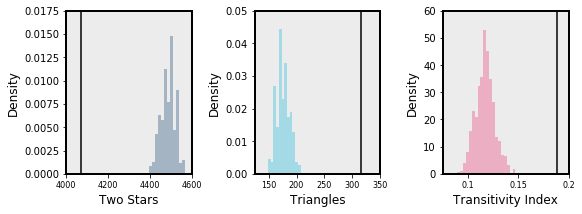

In [14]:
#-------------------------------------#
#- Histograms                        -#
#-------------------------------------#

# Define figure object
exact_test_fig, sbp = plt.subplots(ncols=3, figsize=(9, 3))
ax1 = sbp[0] # Handle for left subplot
ax2 = sbp[1] # Handle for middle subplot
ax3 = sbp[2] # Handle for right subplot

# Plot 1: Histogram of two star triads
plt.axes(ax1) # Select first subplot
plt.hist(Reference_TwoStar, bins=20, normed=True, weights=stb_iwgts, facecolor='#003262', alpha=0.3)
plt.plot((Nyakatoke_TwoStar, Nyakatoke_TwoStar), (0, 1), 'k-') # plot vertical line at x = # two stars in Nyakatoke

# Set axis limits 
plt.ylim([0,0.0175])
plt.xlim([4000,4600])  

# Set tick labels
tick_locs = [4000, 4200, 4400, 4600]
tick_lbls = [4000, 4200, 4400, 4600]
plt.xticks(tick_locs, tick_lbls, fontsize=8)

# Add axis labels
plt.xlabel("Two Stars", fontsize=12)   
plt.ylabel("Density", fontsize=12)

# Clean up the plot, add frames etc.
ax1.patch.set_facecolor('gray')               # Color of background
ax1.patch.set_alpha(0.15)                     # Translucency of background
ax1.grid(False)                               # Remove gridlines from plot

# Add frame around plot
for spine in ['left','right','top','bottom']:
    ax1.spines[spine].set_visible(True)
    ax1.spines[spine].set_color('k')
    ax1.spines[spine].set_linewidth(2)
    
# Tweak spacing between subplots to prevent labels from overlapping
plt.subplots_adjust(wspace=1)

# Plot 2: Histogram of triangle triads
plt.axes(ax2) # Select second subplot
plt.hist(Reference_Triangle, bins=20, normed=True, weights=stb_iwgts, facecolor='#00B0DA', alpha=0.3)
plt.plot((Nyakatoke_Triangle, Nyakatoke_Triangle), (0, 1), 'k-') # plot vertical line at x = # triangles in Nyakatoke

# Set axis limits 
plt.ylim([0,0.05])
plt.xlim([125,350])  

# Set tick labels
tick_locs = [150, 200, 250, 300, 350]
tick_lbls = [150, 200, 250, 300, 350]
plt.xticks(tick_locs, tick_lbls, fontsize=8)

# Add axis labels
plt.xlabel("Triangles", fontsize=12)   
plt.ylabel("Density", fontsize=12)

# Clean up the plot, add frames etc.
ax2.patch.set_facecolor('gray')               # Color of background
ax2.patch.set_alpha(0.15)                     # Translucency of background
ax2.grid(False)                               # Remove gridlines from plot

# Add frame around plot
for spine in ['left','right','top','bottom']:
    ax2.spines[spine].set_visible(True)
    ax2.spines[spine].set_color('k')
    ax2.spines[spine].set_linewidth(2)
    
# Tweak spacing between subplots to prevent labels from overlapping
plt.subplots_adjust(wspace=1)

# Plot 3: Histogram of transitivity index
plt.axes(ax3) # Select third subplot
plt.hist(Reference_TI, bins=20, normed=True, weights=None, facecolor='#EE1F60', alpha=0.3)
plt.plot((Nyakatoke_TI, Nyakatoke_TI), (0, 100), 'k-')      # plot vertical line at x = transitivity index in Nyakatoke

# Set axis limits 
plt.ylim([0,60])
plt.xlim([0.075,0.2])  

# Set tick labels
tick_locs = [0.10, 0.15, 0.20]
tick_lbls = [0.10, 0.15, 0.20]
plt.xticks(tick_locs, tick_lbls, fontsize=8)

# Add axis labels
plt.xlabel("Transitivity Index", fontsize=12)   
plt.ylabel("Density", fontsize=12)

# Clean up the plot, add frames etc.
ax3.patch.set_facecolor('gray')               # Color of background
ax3.patch.set_alpha(0.15)                     # Translucency of background
ax3.grid(False)                               # Remove gridlines from plot

# Add frame around plot
for spine in ['left','right','top','bottom']:
    ax3.spines[spine].set_visible(True)
    ax3.spines[spine].set_color('k')
    ax3.spines[spine].set_linewidth(2)
    
# Tweak spacing between subplots to prevent labels from overlapping
plt.subplots_adjust(wspace=0.5)

# Save figure
plt.savefig(graphics+'Triad_Census_%d_Trials.png' %S, bbox_inches='tight', dpi=500)     

In [15]:
# This imports an attractive notebook format
from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('http://bit.ly/1Bf5Hft').read())